In [1]:
'''
Training Environment:

Python version = 3.8.10
tensorflow-gpu version = 2.9.1
CUDA version = 11.3
cuDNN version = 8.2.1
GPU = NVIDIA Tesla T4
CPU = Intel(R) Xeon(R) Platinum 8255C CPU @ 2.50GHz

Setting Environment:

conda create -n <ENV_NAME> python=3.8.10
pip install tensorflow-gpu=2.9.1
conda install cudnn=8.2.1 # Recommend to use mamba
'''

'\nTraining Environment:\n\nPython version = 3.8.10\ntensorflow-gpu version = 2.9.1\nCUDA version = 11.3\ncuDNN version = 8.2.1\nGPU = NVIDIA Tesla T4\nCPU = Intel(R) Xeon(R) Platinum 8255C CPU @ 2.50GHz\n\nSetting Environment:\n\nconda create -n <ENV_NAME> python=3.8.10\npip install tensorflow-gpu=2.9.1\nconda install cudnn=8.2.1 # Recommend to use mamba\n'

In [38]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import random
import glob
from PIL import Image
from scipy.stats import entropy

In [3]:
# Let GPU memory grow slowly
gpu_list = tf.config.list_physical_devices(device_type='GPU')
if len(gpu_list) > 0:
    for gpu in gpu_list:
        try:
            tf.config.experimental.set_memory_growth(device=gpu, enable=True)
        except RuntimeError as e:
            print(e)
else:
    print('No GPU found.')

2022-08-19 15:55:02.491800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 15:55:02.499790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 15:55:02.500392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
class DataExtract:
    def __init__(self, filename, filepath):
        self.fn = filename
        self.fp = filepath
        self.f = h5py.File(self.fp + self.fn, 'r')

    def save_rgb(self, data):
        rgb = self.f['rgb']
        num = rgb.shape[0]
        for i in range(num):
            image = Image.fromarray(rgb[i])
            image.save('./CityScapes/' + data + '/rgb/' + str(i) + '_rgb.png')

    def save_seg(self, data):
        seg = self.f['seg']
        num = seg.shape[0]
        for i in range(num):
            image = Image.fromarray(np.squeeze((seg[i])))
            image.save('./CityScapes/' + data + '/seg/' + str(i) + '_seg.png')

In [5]:
# Extract Data
path = './'
train_name = 'lab2_train_data.h5'
test_name = 'lab2_test_data.h5'
train_dataextractor = DataExtract(train_name, path)
test_dataextractor = DataExtract(test_name, path)

if os.path.exists('./CityScapes'):
    print('Images exist.')
else:
    os.makedirs('./CityScapes/train/rgb')
    os.makedirs('./CityScapes/train/seg')
    os.makedirs('./CityScapes/test/rgb')
    os.makedirs('./CityScapes/test/seg')
    train_dataextractor.save_rgb('train')
    train_dataextractor.save_seg('train')
    test_dataextractor.save_rgb('test')
    test_dataextractor.save_seg('test')

Images exist.


In [6]:
class DataLoader:
    def __init__(self, rgb_path, seg_path, data):
        self.rgb_path = glob.glob(rgb_path)
        self.seg_path = glob.glob(seg_path)
        self.num = len(self.rgb_path)

        if data == 'train':
            index = np.random.permutation(self.num)
            self.rgb_path = np.array(self.rgb_path)[index]
            self.seg_path = np.array(self.seg_path)[index]

    def read_rgb(self, path):
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels = 3)
        return image

    def read_seg(self, path):
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels = 1)
        return image

    def normalize(self, image, label): 
        # --> [-1, 1]
        image = tf.cast(image, tf.float32) / 127.5 - 1
        label = tf.cast(label, tf.int32)
        return image, label

    def load_dataset(self, rgb_path, seg_path):
        train_img = self.read_rgb(rgb_path)
        label_img = self.read_seg(seg_path)

        image, label = self.normalize(train_img, label_img)
        return image, label

In [7]:
BATCH_SIZE = 35
AUTO = tf.data.experimental.AUTOTUNE

train_dataloader = DataLoader('./CityScapes/train/rgb/*.png', './CityScapes/train/seg/*.png', 'train')
test_dataloader = DataLoader('./CityScapes/test/rgb/*.png', './CityScapes/test/seg/*.png', 'test')

# load train set
train_ds_path = tf.data.Dataset.from_tensor_slices((train_dataloader.rgb_path, train_dataloader.seg_path))
train_ds = train_ds_path.map(train_dataloader.load_dataset, num_parallel_calls = AUTO)
train_ds = train_ds.repeat().batch(BATCH_SIZE).prefetch(AUTO)
# load test set
test_ds_path = tf.data.Dataset.from_tensor_slices((test_dataloader.rgb_path, test_dataloader.seg_path))
test_ds = test_ds_path.map(test_dataloader.load_dataset, num_parallel_calls = AUTO)
test_ds = test_ds.batch(BATCH_SIZE)

2022-08-19 15:55:02.744862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 15:55:02.745681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 15:55:02.746380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 15:55:02.746995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [8]:
def u_net():
    input = layers.Input(shape = (128, 256, 3))

    # ---Down Sampling---
    x1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(64, 3, padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    # (128, 256, 64)

    x2 = layers.MaxPooling2D(padding='same')(x1)
    # (64, 128, 64)

    x2 = layers.Conv2D(128, 3, padding='same', activation='relu')(x2)
    x2 = layers.Dropout(0.5)(x2, training = True)  # Dropout
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(128, 3, padding='same', activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    # (64, 128, 128)

    x3 = layers.MaxPooling2D(padding='same')(x2)
    # (32, 64, 128)

    x3 = layers.Conv2D(256, 3, padding='same', activation='relu')(x3)
    x3 = layers.Dropout(0.5)(x3, training = True)  # Dropout
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Conv2D(256, 3, padding='same', activation='relu')(x3)
    x3 = layers.BatchNormalization()(x3)
    # (32, 64, 256)

    x4 = layers.MaxPooling2D(padding='same')(x3)
    # (16, 32, 256)

    x4 = layers.Conv2D(512, 3, padding='same', activation='relu')(x4)
    x4 = layers.BatchNormalization()(x4)
    x4 = layers.Conv2D(512, 3, padding='same', activation='relu')(x4)
    x4 = layers.BatchNormalization()(x4)
    # (16, 32, 512)

    x5 = layers.MaxPooling2D(padding='same')(x4)
    # (8, 16, 512)

    x5 = layers.Conv2D(1024, 3, padding='same', activation='relu')(x5)
    x5 = layers.BatchNormalization()(x5)
    x5 = layers.Conv2D(1024, 3, padding='same', activation='relu')(x5)
    x5 = layers.BatchNormalization()(x5)
    # (8, 16, 1024) 

    # ---Up Sampling---
    x4_ = layers.Conv2DTranspose(512, 2, strides=2, padding='same', activation='relu')(x5)
    x4_ = layers.BatchNormalization()(x4_)
    # (16, 32, 512)

    x3_ = tf.concat([x4, x4_], axis=-1) # skip connection
    # (16, 32, 1024)
    x3_ = layers.Conv2D(512, 3, padding='same', activation='relu')(x3_)
    x3_ = layers.BatchNormalization()(x3_)
    x3_ = layers.Conv2D(512, 3, padding='same', activation='relu')(x3_)
    x3_ = layers.BatchNormalization()(x3_)
    # (16, 32, 512)

    x3_ = layers.Conv2DTranspose(256, 2, strides=2, padding='same', activation='relu')(x3_)
    x3_ = layers.BatchNormalization()(x3_)
    # (32, 64, 256)

    x2_ = tf.concat([x3, x3_],axis=-1) # skip connection
    # (32, 64, 512)
    x2_ = layers.Conv2D(256, 3, padding='same', activation='relu')(x2_)
    x2_ = layers.Dropout(0.5)(x2_, training = True)  # Dropout
    x2_ = layers.BatchNormalization()(x2_)
    x2_ = layers.Conv2D(256, 3, padding='same', activation='relu')(x2_)
    x2_ = layers.BatchNormalization()(x2_)
    # (32, 64, 256)

    x2_ = layers.Conv2DTranspose(128, 2, strides=2, padding='same', activation='relu')(x2_)
    x2_ = layers.BatchNormalization()(x2_)
    # (64, 128, 128)

    x1_ = tf.concat([x2, x2_], axis=-1) # skip connection
    # (64, 128, 256)
    x1_ = layers.Conv2D(128, 3, padding='same', activation='relu')(x1_)
    x1_ = layers.BatchNormalization()(x1_)
    x1_ = layers.Conv2D(128, 3, padding='same', activation='relu')(x1_)
    x1_ = layers.BatchNormalization()(x1_)
    # (64, 128, 128)

    x1_ = layers.Conv2DTranspose(64, 2, strides=2, padding='same', activation='relu')(x1_)
    x1_ = layers.BatchNormalization()(x1_)
    # (128, 256, 64)

    x = tf.concat([x1, x1_], axis=-1)
    # (128, 256, 128)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Dropout(0.5)(x, training = True)  # Dropout
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    # (128, 256, 64)

    output = layers.Conv2D(34, 1, padding='same', activation='softmax')(x)
    # (128, 256, 34)
    
    return keras.Model(inputs = input,outputs = output)

In [9]:
model = u_net()
model.summary()

if os.path.exists('./model_structure.png'):
    pass
else:
    tf.keras.utils.plot_model(model, to_file = 'model_structure.png', show_shapes = True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [10]:
# Rewrite MIOU(original version use one-hot coding)
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, y_true = None, y_pred = None, num_classes = None, name = None, dtype = None):
        super(MeanIoU, self).__init__(num_classes = num_classes,name = name, dtype = dtype)

    def update_state(self, y_true, y_pred, sample_weight = None):
        y_pred = tf.math.argmax(y_pred, axis = -1)
        return super().update_state(y_true, y_pred, sample_weight)
        
# Compile model
model.compile(optimizer = keras.optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy', metrics = ['acc', MeanIoU(num_classes = 34)])

In [11]:
EPOCH = 50

# train_dataloader = DataLoader('./CityScapes/train/rgb/*.png', './CityScapes/train/seg/*.png', 'train')
# test_dataloader = DataLoader('./CityScapes/test/rgb/*.png', './CityScapes/test/seg/*.png', 'test')

train_step = train_dataloader.num // BATCH_SIZE
test_step = test_dataloader.num // BATCH_SIZE

checkpoint_dir = './models/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir, 
    verbose = 1, 
    save_weights_only = True, 
    save_freq = 5 * BATCH_SIZE
    )

history = model.fit(
    train_ds,
    epochs              = EPOCH,
    steps_per_epoch     = train_step,
    validation_data     = test_ds,
    validation_steps    = test_step,
    callbacks           = [cp_callback]
    )

model.save('model.h5')
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/50


2022-08-19 15:55:07.965241: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


85/85 [==============================] - 116s 1s/step - loss: 1.8103 - acc: 0.5022 - mean_io_u: 0.0649 - val_loss: 12.2899 - val_acc: 0.3498 - val_mean_io_u: 0.0299
Epoch 2/50
85/85 [==============================] - 90s 1s/step - loss: 1.3631 - acc: 0.5616 - mean_io_u: 0.0863 - val_loss: 1.5125 - val_acc: 0.5320 - val_mean_io_u: 0.0757
Epoch 3/50
 4/85 [>.............................] - ETA: 1:21 - loss: 1.3623 - acc: 0.5634 - mean_io_u: 0.0901
Epoch 3: saving model to ./models/cp.ckpt
85/85 [==============================] - 93s 1s/step - loss: 1.3284 - acc: 0.5656 - mean_io_u: 0.0883 - val_loss: 1.5766 - val_acc: 0.5428 - val_mean_io_u: 0.0837
Epoch 4/50
85/85 [==============================] - 90s 1s/step - loss: 1.3099 - acc: 0.5682 - mean_io_u: 0.0910 - val_loss: 1.4262 - val_acc: 0.5513 - val_mean_io_u: 0.0966
Epoch 5/50
 9/85 [==>...........................] - ETA: 1:16 - loss: 1.3144 - acc: 0.5684 - mean_io_u: 0.0943
Epoch 5: saving model to ./models/cp.ckpt
85/85 [===========

In [14]:
model_infer = u_net()
model_infer.load_weights('./checkpoints/my_checkpoint')

In [17]:
def fetch_origin(num, channels = 3):
    img = tf.io.read_file('./CityScapes/test/rgb/' + str(num) + '_rgb.png')
    img = tf.image.decode_png(img, channels)
    return img

def fetch_label(num, palette, channels = 1):
    img = np.array(Image.open('./CityScapes/test/seg/' + str(num) + '_seg.png'))
    img = Image.fromarray(img, 'P')
    img.putpalette(palette)
    return img

1/1 [==============================] - 0s 19ms/step


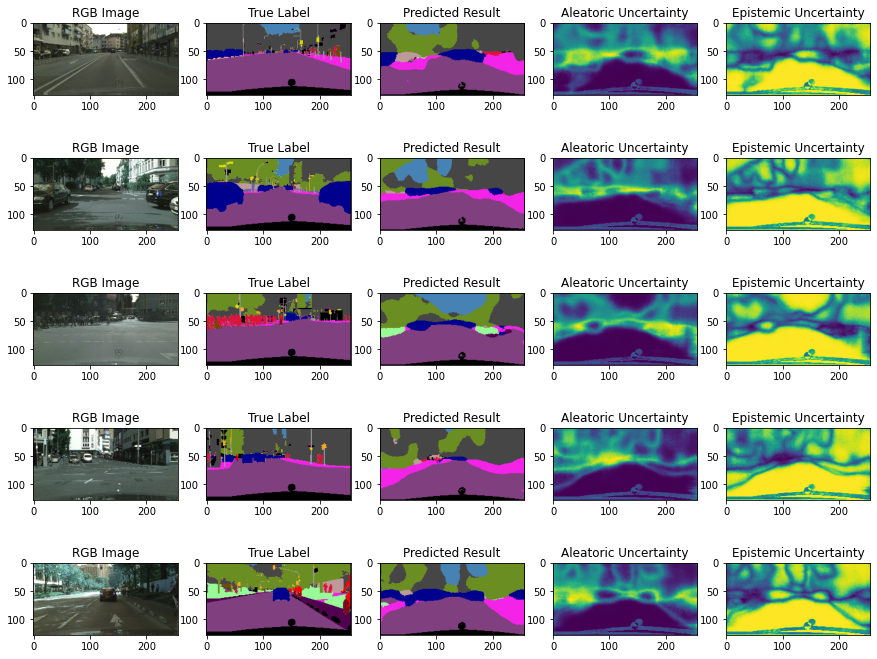

In [92]:
imgnum_to_predict = [2, 4, 6, 8, 10]
label_list = []
origin_image_list = []
befor_predict_list = []
output_image_list = []
final_predicted_list = []
color_codes = test_dataextractor.f['color_codes']
palette = list(color_codes[:].reshape(-1))
for num in imgnum_to_predict:
    origin_image_list.append(fetch_origin(num))
    label_list.append(fetch_label(num, palette))

    tmp = origin_image_list[int(num / 2 - 1)]
    tmp = tf.cast(tmp, tf.float32) / 127.5 - 1
    tmp = tf.expand_dims(tmp, axis = 0)
    befor_predict_list.append(tmp)

if os.path.exists('./results') == False:
    os.makedirs('./results')

count = 0
al_tmp_list = []
ep_tmp_list = []
tmp_list = []
al_list = []
ep_list = []
for img in befor_predict_list:
    for t in range(5):
        output = model_infer.predict(img)
        tmp_list.append(output)
        output_ep = tf.nn.softmax(output)
        output_ep = tf.reduce_max(output_ep, axis = -1)
        ep_tmp_list.append(np.squeeze(output_ep))

        output_al = tf.reduce_mean(output, axis = 0)
        output_al = entropy(output_al, axis = -1)
        al_tmp_list.append(output_al)
    
    output = np.sum(np.array(tmp_list), axis = 0) / 5
    output_image_list.append(output)
    
    al = np.sum(np.array(al_tmp_list), axis = 0) / 5
    al_list.append(al)

    ep = np.sum(np.array(ep_tmp_list), axis = 0) / 5
    ep_list.append(ep)

    output = tf.argmax(output, axis = -1)
    
    output = output.numpy().astype(np.uint8)
    output = Image.fromarray(np.squeeze(output))
    output.save('./results/' + str(count) + '.png')
    output = np.array(Image.open('./results/' + str(count) + '.png'))
    output = Image.fromarray(output, 'P')
    output.putpalette(palette)
    final_predicted_list.append(output)
    output.save('./results/' + str(count) + '_palette.png')
    al_tmp_list = []
    ep_tmp_list = []
    tmp_list = []
    count += 1

plt.figure(figsize=(15, 12))
for i in range(5):
    plt.subplot(5, 5, i * 5 + 1)
    plt.title('RGB Image')
    plt.imshow(origin_image_list[i])

    plt.subplot(5, 5, i * 5 + 2)
    plt.title('True Label')
    plt.imshow(label_list[i])

    plt.subplot(5, 5, i * 5 + 3)
    plt.title('Predicted Result')
    plt.imshow(final_predicted_list[i])

    plt.subplot(5, 5, i * 5 + 4)
    plt.title('Aleatoric Uncertainty')
    plt.imshow(al_list[i])

    plt.subplot(5, 5, i * 5 + 5)
    plt.title('Epistemic Uncertainty')
    plt.imshow(ep_list[i])

plt.savefig('result.eps', dpi = 300)